# Experiment 7: Generalize experiment 3 (impact of open world) to include more classifiers

We want to see how well an classifier trained on dataset with few sources performs on a dataset with more sources. Compare that to a classifier that has seen the full distribution of sources.  In other words, this is **assessing dataset shift**.

In this notebook, we extend experiment 3 by adding the XGBoost and Isolation Forest classifiers, in addition to the Naive Bayes classifier. We find XGBoost has slightly better open set generalization than the Naive Bayes classifier.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import subprocess
import random
import pickle
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm

import uncertainties

from image_compression_attribution.common.code.models import quant_matrices, compr_levels
from image_compression_attribution.common.code.summarize_quant_matrices import summarize_compression_features

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#WARNING: this method does not seem to work well when there are large gaps
#in the ROC curve. Hence, only use this if you have interpolated between
#ROC curve data points to fill in the roc curve on a grid with small intervals.
#https://github.com/scikit-learn/scikit-learn/issues/15247#issuecomment-542138349
def calculate_eer(fpr, tpr):
    '''
    Returns the equal error rate for a binary classifier output.
    '''
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer
  
#---------------------------------------------------------------
#Code to combine mean value and uncertainty estimate into
#one formatted string, like 3.14 +/- .02 becomes "3.14(2)"

import string

class ShorthandFormatter(string.Formatter):
  """https://pythonhosted.org/uncertainties/user_guide.html"""

  def format_field(self, value, format_spec):
    if isinstance(value, uncertainties.UFloat):
      return value.format(format_spec+'S')  # Shorthand option added
    # Special formatting for other types can be added here (floats, etc.)
    else:
      # Usual formatting:
      return super(ShorthandFormatter, self).format_field(
        value, format_spec)

def uncertainty_format_arrays(mean_vals, uncertainty_vals):
  frmtr_uncertainty = ShorthandFormatter()
  
  vals_formatted = []
  for mean, uncert in zip(mean_vals, uncertainty_vals):
    number = uncertainties.ufloat(mean, uncert)
    str_formatted = frmtr_uncertainty.format("{0:.1u}", number)
    vals_formatted.append(str_formatted)
  return vals_formatted

/app/image_compression_attribution/common/code/summarize_quant_matrices.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  #works in notebooks or scripts


In [3]:
RND_SEED=1234
np.random.seed(RND_SEED)

In [4]:
SUMMARY_FILE = "/app/dataset/data.csv"

RESULTS_FOLDER = "results/exp_07"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

df = pd.read_csv(SUMMARY_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

#Drop non-image files, e.g. html files returned
#due to download errors

df, df_dropped = df[ df['mime'].str.startswith('image') ].reset_index(drop=True), \
  df[ ~df['mime'].str.startswith('image') ].reset_index(drop=True)

sources = sorted(list(df['source'].unique()))

# Encode features

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
#Guide to LabelEncoder:  
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


#create numerical class labels for quantization categorical names (suitable for 
#use as  ML training feature vector)
le_qs = preprocessing.LabelEncoder()
le_qs.fit(df['q_name'])
df['q_name_class'] = le_qs.transform(df['q_name'])

sources = sorted(list(df['source'].unique()))
le_sources = preprocessing.LabelEncoder()
le_sources.fit(sources)
df['source_class'] = le_sources.transform(df['source'])

#----------------------------------------------------------------------------
#Make 3 separate encoded features, for use with non-naive bayes classifiers
le_compression = preprocessing.LabelEncoder()
le_compression.fit(df['compression'])
df['compression_class'] = le_compression.transform(df['compression'])

le_mime = preprocessing.LabelEncoder()
le_mime.fit(df['mime'])
df['mime_class'] = le_mime.transform(df['mime'])

le_quant_matrix = preprocessing.LabelEncoder()
le_quant_matrix.fit(df['q_hash'])
df['q_hash_class'] = le_quant_matrix.transform(df['q_hash'])

In [6]:
df

articleUrl                                                       articleHash                                                                                                                                                           imageUrl      source        mime  compression                            q_hash          q_name                 timestamp  q_name_class  source_class  \
0                     https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346                                  4de7b04b17622bc838468486216f9878      https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092 2020-05-25 00:00:00+00:00           254             0   
1      https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562                                  99770eadd0f12e1c63df525a8c739f8c    https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092 2017-01-11 00:00:00+00:00           254             0   
2              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092 2021-01-31 00:00:00+00:00           254             0   
3              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612  https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862  abc.net.au  image/webp           92                               NaN        webp_092 2021-01-31 00:00:00+00:00           254             0   
4              https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128                                  90c0fcf3f9dd12d2770ac4092ca9f612    https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092 2021-01-31 00:00:00+00:00           254             0   
...                                                                                                          ...                                                               ...                                                                                                                                                                ...         ...         ...          ...                               ...             ...                       ...           ...           ...   
64680                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                                          https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg     voanews  image/jpeg           50  48c9be01d998be93be725587386b3028  jpeg_050_48c9b 2016-09-15 18:20:00+00:00            13            29   
64681                    https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                 https://im-media.vo

# Experiment 7

Process:
1. Test set: contains samples from all sources.
    1. select e.g. 40% of articles from a claimed source. 
    1. Select equal # of articles from all other sources.
1. Training data:
    1. For both train sets, keep all of the remaining data from the source (60% of source), which is NOT included in the test set.
    1. For the small dataset, also: keep all remaing articles (not in the test set) from 1/2 of the remaining sources. Randomly sample 1/2 the sources.
    1. For the large dataset, randomly sample an equal number of images from all of the remaining sources. This ensures both test sets are roughly the same size.
Note: the big and small train sets are the same size, but the small train set has 1/2 the number of sources as the big train set.


Train 2 classifiers (one on the small train set, one on the large train set.) Compare them both on the test set.

In [7]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import IsolationForest

In [ ]:
#Prepare Train and Test Split.
#Do random sampling to make train/test split. 
#Stratify on classes = news sources.
PERCENT_TEST = 0.40

#in small set, keep this fraction of remaining sources
PERCENT_SOURCES_TO_KEEP_IN_SMALLSET = .5

all_q_name_vals = sorted(df['q_name'].unique())

#Sample from articles (so we can keep images from articles grouped together)
df_articles = df[['articleHash', 'source', 'source_class']].drop_duplicates()

NUM_TRIALS = 5

model_names = ["NB_LLR_QM1f",
               "NB_Ps_QM1f",
               "NB_Psbar_QM1f",
               "XGB_QM3f",
               "XGB_QM1f",
               "IF_QM3f",
               "IF_QM1f"]

size_names = ['small', 'large'] #train large and small models

models = {}          #access like models[model_name][size]
for model_name in model_names:
  models[model_name] = {}

#Create nested dict to store results, like results[source][model_name][size][trial]
results = {}
for source in sources:
  results[source] = {}
  for model_name in model_names:
    results[source][model_name] = {}
    for size_name in size_names:
      results[source][model_name][size_name] = []    

for trial in tqdm(range(NUM_TRIALS)):
  
  numsamples_balanced_testset=[]

  for source in sources:
    remaining_sources = [x for x in sources if x!=source]

    #===========================================================================
    #Form test set:

    #get all articles from the source,
    df_articles_from_source = df_articles[df_articles['source']==source]
    df_articles_not_from_source = df_articles[df_articles['source']!=source]

    #Randomly sample articles to build test set, e.g. 40% of articles from the source:
    num_test_articles_from_source = int(PERCENT_TEST*len(df_articles_from_source))
    df_test_articles_from_source = df_articles_from_source.sample(num_test_articles_from_source)
    #then sample equal number of articles not from the source, but from ALL remaining sources
    df_test_articles_not_from_source = df_articles_not_from_source.sample(num_test_articles_from_source)
    df_test_articles = pd.concat([df_test_articles_from_source, df_test_articles_not_from_source])

    #------------------------------------
    #Form training set: keep all remaining samples from the source:

    #whatever is left is available for training
    df_train_articles_all = df_articles[ ~df_articles['articleHash'].isin(df_test_articles['articleHash'])]

    df_train_articles_from_source = df_train_articles_all[df_train_articles_all['source']==source]
    num_train_articles_from_source = len(df_train_articles_from_source)

    #------------------
    #Make 2 train sets of articles not from the source:

    #1st make a smaller training set with e.g. 50% of the sources

    num_remaining_sources_to_keep_small = int(PERCENT_SOURCES_TO_KEEP_IN_SMALLSET * len(remaining_sources))
    #get a list of e.g. 50% of the remaining sources, to keep in a small train set
    sample_remaining_sources = list(pd.Series(remaining_sources).sample(num_remaining_sources_to_keep_small))

    #keep all articles from those sources
    df_train_articles_not_from_source_small = df_train_articles_all[df_train_articles_all['source'].isin(sample_remaining_sources)]

    #-------
    #also make similarly-sized training set with all sources.

    num_train_articles_not_from_source = len(df_train_articles_not_from_source_small)

    #large train set: randomly sample equal # of articles from all remaining sources:
    df_train_articles_not_from_source_big = df_train_articles_all[df_train_articles_all['source']!=source].sample(num_train_articles_not_from_source)

    #---------
    #Combine train sets with and without the source:

    df_train_articles_small = pd.concat([df_train_articles_from_source, df_train_articles_not_from_source_small])
    df_train_articles_big   = pd.concat([df_train_articles_from_source, df_train_articles_not_from_source_big])

    assert len(df_train_articles_small)==len(df_train_articles_big)
    assert len(df_train_articles_small['source'].unique())<=len(df_train_articles_big['source'].unique())

    #------------------

    #Get all images articles in train/test splits:
    df_test = df[ df['articleHash'].isin(df_test_articles['articleHash']) ].reset_index()
    #Set ground truth label: 1 if image misattributed, else 0
    df_test['is_misattributed'] = np.array(df_test['source']!=source, dtype=int)

    df_train_small = df[ df['articleHash'].isin(df_train_articles_small['articleHash']) ].reset_index()
    df_train_small['is_misattributed'] = np.array(df_train_small['source']!=source, dtype=int)
    df_train_big   = df[ df['articleHash'].isin(df_train_articles_big['articleHash']) ].reset_index()
    df_train_big['is_misattributed'] = np.array(df_train_big['source']!=source, dtype=int)

    sources_train_small = sorted(df_train_small['source'].unique())
    sources_train_big = sorted(df_train_big['source'].unique())

    #===========================================================================
    #Fit models
    
    df_train_list = [df_train_small, df_train_big]
    sources_train_list = [sources_train_small, sources_train_big]
    
    numsamples_balanced_testset.append(len(df_test))
    
    for indx, size_name in enumerate(size_names):

      df_train_size = df_train_list[indx]
      
      #-----------------------------------
      #Fit Naive Bayes
      
      models["NB_LLR_QM1f"][size_name] = quant_matrices.attribution_quant_matrices()
      models["NB_LLR_QM1f"][size_name].fit(df_train_size[['source', 'q_name']], compr_category_names=all_q_name_vals)

      #Fit XGBoost
      models["XGB_QM3f"][size_name] = xgb.XGBClassifier()
      models["XGB_QM3f"][size_name].fit(df_train_size[["compression_class", "mime_class", "q_hash_class"]], 
                            df_train_size['is_misattributed'])
      
      models["XGB_QM1f"][size_name] = xgb.XGBClassifier()
      models["XGB_QM1f"][size_name].fit(df_train_size[["q_name_class"]], 
                            df_train_size['is_misattributed'])
      
      #Train Isolation Forest:
      models["IF_QM3f"][size_name] = IsolationForest()
      models["IF_QM3f"][size_name] = models["IF_QM3f"][size_name].fit(df_train_size[["compression_class", "mime_class", "q_hash_class"]])

      #Train Isolation Forest:
      models["IF_QM1f"][size_name] = IsolationForest()
      models["IF_QM1f"][size_name] = models["IF_QM1f"][size_name].fit(df_train_size[["q_name_class"]])
      
      #-----------------------------------
      #prediction on test set
      claimed_source_list = [source]*len(df_test)

      #-----------
      #NB, QM features
      LLRs_isfake_qm, probs_fromsource_qm, probs_notfromsource_qm, \
        unrecognized_sources_qm = models["NB_LLR_QM1f"][size_name].predict(df_test['q_name'], claimed_source_list)
      df_test['scores_NB_LLR_QM1f_' + size_name] = LLRs_isfake_qm
      
      #Alternative scores (not LLR), for other Naive Bayes variants
      df_test['scores_NB_Ps_QM1f_' + size_name] = 1.0/np.array(probs_fromsource_qm)
    
      df_test['scores_NB_Psbar_QM1f_' + size_name] = probs_notfromsource_qm
      
      #----------
      #XGBoost: using 3 separate features
      scores = models["XGB_QM3f"][size_name].predict_proba(df_test[["compression_class", "mime_class", "q_hash_class"]])
      df_test['scores_XGB_QM3f_' + size_name] = scores[:,1]

      #XGBoost: using 1 combined feature
      scores = models["XGB_QM1f"][size_name].predict_proba(df_test[["q_name_class"]])
      df_test['scores_XGB_QM1f_' + size_name] = scores[:,1]
      
      #----------
      #IsolationForest: 3 separate features
      scores = models["IF_QM3f"][size_name].decision_function(df_test[["compression_class", "mime_class", "q_hash_class"]])
      #Warning: shorter scores are more anomalous (likely not from the claimed source) so negate
      df_test['scores_IF_QM3f_' + size_name] = - scores

      #IsolationForest: 1 combined feature
      scores = models["IF_QM1f"][size_name].decision_function(df_test[["q_name_class"]])
      #Warning: shorter scores are more anomalous (likely not from the claimed source) so negate
      df_test['scores_IF_QM1f_' + size_name] = - scores
      
      #-----------------------------------
      #Compute ROC curve for this source:
      
      for model_name in model_names:
        score_name = "scores_" + model_name + "_" + size_name

        fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test[score_name], pos_label=1)
        roc_auc = auc(fpr, tpr)

        results_tmp = {'size_name': size_name,
                       'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test[score_name],
                       'label_isfake': df_test['is_misattributed'],
                       'num_train_sources':len(df_train_size['source'].unique()),
                       'num_test_sources':len(df_test['source'].unique())}
        results[source][model_name][size_name].append(results_tmp)



## Note:
The number of sources in training and test sets is not necessarily fixed, because random sampling is done.

Ideally, for the **big num sources** set, there would be all sources (30) present in both training and test set.
But this is not always the case. The exceptions are most common where the total number of samples is small.
Then, in the test set, which is smaller than the train set (40%, not 60%), it's common to have fewer than 30 sources.

Ideally, for the **small num sources** set, there would be all sources (30) in testing and half the sources (15)
in the training set.  In practice, it's commong to have < 30 in the smaller test set, and exactly 15 in the train set (which
occurs because there are fewer sources, 15 not 30, so more chances to sample each one.)

In [9]:
for src in sources:
  print(src)
  print(" set: #-train-src | #-test-src | len-test-set")
  for size_name in size_names:
    for trial in range(5):
      print("  {} {} | {} | {}".format(size_name,
                                      results[src][model_names[0]][size_name][trial]['num_train_sources'], 
                                      results[src][model_names[0]][size_name][trial]['num_test_sources'], 
                                      results[src][model_names[0]][size_name][trial]['numsamples']))

abc.net.au
 set: #-train-src | #-test-src | len-test-set
  small 15 | 30 | 3259
  small 15 | 30 | 3038
  small 15 | 29 | 2988
  small 15 | 30 | 3061
  small 15 | 29 | 2992
  large 30 | 30 | 3259
  large 30 | 30 | 3038
  large 30 | 29 | 2988
  large 30 | 30 | 3061
  large 30 | 29 | 2992
airforcetimes.com
 set: #-train-src | #-test-src | len-test-set
  small 15 | 27 | 406
  small 15 | 29 | 431
  small 15 | 23 | 417
  small 15 | 26 | 438
  small 15 | 26 | 417
  large 30 | 27 | 406
  large 30 | 29 | 431
  large 30 | 23 | 417
  large 30 | 26 | 438
  large 30 | 26 | 417
aljazeera
 set: #-train-src | #-test-src | len-test-set
  small 15 | 26 | 2157
  small 15 | 28 | 2148
  small 15 | 28 | 2131
  small 15 | 27 | 2102
  small 15 | 28 | 2087
  large 30 | 26 | 2157
  large 30 | 28 | 2148
  large 30 | 28 | 2131
  large 30 | 27 | 2102
  large 30 | 28 | 2087
allafrica.com
 set: #-train-src | #-test-src | len-test-set
  small 15 | 19 | 185
  small 15 | 19 | 169
  small 15 | 23 | 211
  small 15 | 18 |

In [10]:
print(len(df_train_articles_from_source))

df_train_articles_from_source['source'].unique()

117


array(['voanews'], dtype=object)

In [11]:
print(len(df_train_articles_not_from_source_small))

df_train_articles_not_from_source_small['source'].unique()

13775


array(['allafrica.com', 'americanfreepress', 'canadiandimension',
       'centurywire', 'globaltimes', 'hindustantimes.com',
       'koreatimes.co.kr', 'militarytimes.com', 'navytimes.com', 'nst',
       'rferl', 'russiatoday', 'timesofindia', 'trtworld'], dtype=object)

In [12]:
print(len(df_train_articles_not_from_source_big))

df_train_articles_not_from_source_big['source'].unique()

13775


array(['taipeitimes', 'navytimes.com', 'france24', 'egypttoday',
       'timesofindia', 'thestar.com', 'hindustantimes.com',
       'straitstimes', 'abc.net.au', 'aljazeera', 'koreatimes.co.kr',
       'sbs.com.au', 'trtworld', 'oneindia.com', 'airforcetimes.com',
       'canadiandimension', 'rferl', 'asahi.com', 'ceasefire',
       'japantimes.co.jp', 'militarytimes.com', 'globaltimes',
       'centurywire', 'russiatoday', 'americanfreepress', 'bbc',
       'ghanaiantimes.com.gh', 'nst', 'allafrica.com'], dtype=object)

In [13]:
print(len(df_test))

df_test['source'].unique()

499


array(['abc.net.au', 'aljazeera', 'canadiandimension', 'ceasefire',
       'centurywire', 'egypttoday', 'france24', 'ghanaiantimes.com.gh',
       'globaltimes', 'hindustantimes.com', 'koreatimes.co.kr',
       'militarytimes.com', 'oneindia.com', 'sbs.com.au', 'taipeitimes',
       'thestar.com', 'timesofindia', 'trtworld', 'voanews'], dtype=object)

In [14]:
df_train_small

index                                                                               articleUrl                                                       articleHash                                                                                                                                            imageUrl         source        mime  compression                            q_hash          q_name                 timestamp  q_name_class  source_class  compression_class  mime_class  \
0       8391                                          https://allafrica.com/stories/202102250325.html                                  39a6264390d0c395a9014a840e1acfd4                          https://cdn04.allafrica.com/download/pic/main/main/csiid/00520488:109bf96cbe6dcb25907f7afaf0e392fd:arc614x376:w735:us1.jpg  allafrica.com  image/jpeg           88  b48a23653466e4fdbfa2824590e390ec  jpeg_088_b48a2 2021-02-25 00:00:00+00:00           139             3                 42           1   
1       8392                                          https://allafrica.com/stories/202009150646.html                                  68eb4d21d0ea25cfaba7d68ce0d79709                          https://cdn03.allafrica.com/download/pic/main/main/csiid/00480703:42e50b5fb9f150490e1ec23541a55595:arc614x376:w735:us1.jpg  allafrica.com  image/jpeg           88  b48a23653466e4fdbfa2824590e390ec  jpeg_088_b48a2 2020-09-15 00:00:00+00:00           139             3                 42           1   
2       8393                                          https://allafrica.com/stories/201912120268.html                                  71ca70c909b903d8bf0d4888006c89e9                          https://cdn07.allafrica.com/download/pic/main/main/csiid/00501442:e6d8ff40817cfd58e7597aeec4c0afec:arc614x376:w735:us1.jpg  allafrica.com  image/jpeg           88  b48a23653466e4fdbfa2824590e390ec  jpeg_088_b48a2 2019-12-12 00:00:00+00:00           139             3                 42           1   
3       8394                                          https://allafrica.com/stories/202007200002.html                                  10ccb031061f8fb4d2ec85ddf88424eb                          https://cdn05.allafrica.com/download/pic/main/main/csiid/00561196:bfd63eb48f30cd99f38268d3b9dc5b07:arc614x376:w735:us1.jpg  allafrica.com  image/jpeg           88  b48a23653466e4fdbfa2824590e390ec  jpeg_088_b48a2 2020-07-20 00:00:00+00:00           139             3                 42           1   
4       8395                                          https://allafrica.com/stories/202103260778.html                                  b338ab0b475344cace1b42264243279e                          https://cdn06.allafrica.com/download/pic/main/main/csiid/00580019:3a5abbef0af11a495fe9bcbfe0ffa2bb:arc614x376:w735:us1.jpg  allafrica.com  image/jpeg           88  b48a23653466e4fdbfa2824590e390ec  jpeg_088_b48a2 2021-03-26 00:00:00+00:00           139             3                 42           1   
...      ...                                                                                      ...                                                               ...                                                                                                                                                 ...            ...         ...          ...                               ...             ...                       ...           ...           ...                ...         ...   
21550  64680  https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                           https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg        voanews  image/jpeg           50  48c9be01d998be93be725587386b3028  jpeg_050_48c9b 2016-09-15 18:20:00+00:00            13            29                 11           1   
21551  64681  https://www.voanews.com/usa/police-ohio-c

In [15]:
df_train_big

index                                                                                                      articleUrl                                                       articleHash                                                                                                                                                            imageUrl      source        mime  compression                            q_hash          q_name                 timestamp  q_name_class  source_class  \
0          9  https://www.abc.net.au/news/2012-05-06/families-of-school-kids-in-line-for-budget-boost/3993816?site=melbourne                                  e1aea69b9a46fdb9402f6e37f326d0d2      https://live-production.wcms.abc-cdn.net.au/3d860acc26f590b430728c1a133e84a7?impolicy=wcms_crop_resize&cropH=575&cropW=1024&xPos=0&yPos=0&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092 2012-05-06 00:00:00+00:00           254             0   
1         10  https://www.abc.net.au/news/2012-05-06/families-of-school-kids-in-line-for-budget-boost/3993816?site=melbourne                                  e1aea69b9a46fdb9402f6e37f326d0d2      https://live-production.wcms.abc-cdn.net.au/452b24266aeeb838a5e7cf1fcfc93129?impolicy=wcms_crop_resize&cropH=447&cropW=795&xPos=28&yPos=9&width=862&height=485  abc.net.au  image/webp           92                               NaN        webp_092 2012-05-06 00:00:00+00:00           254             0   
2         11  https://www.abc.net.au/news/2014-07-15/uk-foreign-minister-william-hague-steps-down-from-post-in-surpr/5597004                                  a4f6702e4dc161e9cbeb90b35bb0fef1       https://live-production.wcms.abc-cdn.net.au/d22054f15c311a1aef79d63aafc3d544?impolicy=wcms_crop_resize&cropH=559&cropW=840&xPos=0&yPos=9&width=862&height=575  abc.net.au  image/jpeg           87  66c5a2b5d9805c6cb0a92649f8fa98c7  jpeg_087_66c5a 2014-07-15 00:00:00+00:00           129             0   
3         12           https://www.abc.net.au/news/2017-11-23/sofina-nikat-avoids-jail-sentence-for-killing-daughter/9182912                                  3793b78411862634440a13dd0aa2a81f      https://live-production.wcms.abc-cdn.net.au/f059df26429d872a46496ce3f630833e?impolicy=wcms_crop_resize&cropH=713&cropW=713&xPos=6&yPos=74&width=862&height=862  abc.net.au  image/webp           92                               NaN        webp_092 2017-11-23 00:00:00+00:00           254             0   
4         13           https://www.abc.net.au/news/2017-11-23/sofina-nikat-avoids-jail-sentence-for-killing-daughter/9182912                                  3793b78411862634440a13dd0aa2a81f  https://live-production.wcms.abc-cdn.net.au/c09ab13ac4fe01e42696ad2cc772a5a2?impolicy=wcms_crop_resize&cropH=1333&cropW=2007&xPos=53&yPos=256&width=862&height=575  abc.net.au  image/webp           92                               NaN        webp_092 2017-11-23 00:00:00+00:00           254             0   
...      ...                                                                                                             ...                                                               ...                                                                                                                                                                 ...         ...         ...          ...                               ...             ...                       ...           ...           ...   
25546  64680                         https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting  59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5                                           https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg     voanews  image/jpeg           50  48c9be01d998be93be725587386b3028  jpeg_050_48c9b 2016-09-15 18:20:00+00:00            13            29   
25547  64681   

## Summarize results

In [16]:
model_names[0]

'NB_LLR_QM1f'

In [17]:
model_names 

['NB_LLR_QM1f',
 'NB_Ps_QM1f',
 'NB_Psbar_QM1f',
 'XGB_QM3f',
 'XGB_QM1f',
 'IF_QM3f',
 'IF_QM1f']

In [18]:
# results[source][s[0]]['large'][trial]['numsamples']
results[source][model_names[0]]['large'][trial]['numsamples']

499

In [19]:
FPR_THRESHOLD = 0.005  # compute TPR @ this FPR = 0.5%

# numsamples_balanced_testset = []

roc_summaries = {}
#Make nested dict to hold summaries, like roc_summaries[source][model_name][size]
for source in sources:
  #numsamples_balanced_testset.append(results[source][model_name][size_name]['numsamples'])
  roc_summaries[source] = {}
  for model_name in model_names:
    roc_summaries[source][model_name] = {}

for size_name in size_names:
  for source in sources:
    for model_name in model_names:
      AUCs_per_trial = []
      tpr_per_trial = []
      fpr_per_trial = []
      tprs_at_fpr_threshold = []
      for trial in range(NUM_TRIALS):
        AUCs_per_trial.append(results[source][model_name][size_name][trial]['auc'])
        fpr = results[source][model_name][size_name][trial]['fpr']
        tpr = results[source][model_name][size_name][trial]['tpr']
        fpr_per_trial.append(fpr)
        tpr_per_trial.append(tpr)
        tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
      AUCs_mean = np.mean(AUCs_per_trial)
      AUCs_std = np.std(AUCs_per_trial)
      tpr_at_fpr_mean = np.mean(tprs_at_fpr_threshold)
      
      roc_summaries[source][model_name][size_name] = {'AUC_mean':AUCs_mean, 
                                                      'AUC_std':AUCs_std, 
                                                      'tpr_at_fpr_mean':tpr_at_fpr_mean}
  
#   numsamples_balanced_testset.append(results_per_trial_qm_small[trial][source]['numsamples'])

#---------------------------------------
#Pack ROC summaries into a dataframe

#number of images varies a little per trial, since we sample by articles not by images
#so compute mean # of images across trials. Make integer to avoid reader confusion.
test_sizes_mean = []
for source in sources:
  test_sizes = [results[source][model_names[0]]['large'][trial]['numsamples'] for trial in range(NUM_TRIALS)]
  test_sizes_mean.append(int(np.mean(np.array(test_sizes))))
  
summary_dict = {'source':sources, 'test_size_mean': test_sizes_mean}

for metric_name in ['AUC_mean', 'AUC_std', 'tpr_at_fpr_mean']:
  for model_name in model_names:
    for size_name in size_names:
      column_name = metric_name + "_" + model_name + "_" + size_name
      metric_array = [ roc_summaries[source][model_name][size_name][metric_name] for source in sources ]
      summary_dict[column_name] = metric_array
      
df_summary = pd.DataFrame(summary_dict)
  

In [20]:
df_summary.head()

source  test_size_mean  AUC_mean_NB_LLR_QM1f_small  AUC_mean_NB_LLR_QM1f_large  AUC_mean_NB_Ps_QM1f_small  AUC_mean_NB_Ps_QM1f_large  AUC_mean_NB_Psbar_QM1f_small  AUC_mean_NB_Psbar_QM1f_large  AUC_mean_XGB_QM3f_small  AUC_mean_XGB_QM3f_large  AUC_mean_XGB_QM1f_small  AUC_mean_XGB_QM1f_large  AUC_mean_IF_QM3f_small  AUC_mean_IF_QM3f_large  AUC_mean_IF_QM1f_small  AUC_mean_IF_QM1f_large  AUC_std_NB_LLR_QM1f_small  AUC_std_NB_LLR_QM1f_large  AUC_std_NB_Ps_QM1f_small  \
0         abc.net.au            3067                    0.841106                    0.901894                   0.882450                   0.882450                      0.313132                      0.350860                 0.881217                 0.903279                 0.882143                 0.903526                0.550716                0.471899                0.673279                0.663968                   0.043428                   0.003945                  0.003740   
1  airforcetimes.com             421                    0.764029                    0.849489                   0.872017                   0.872017                      0.235015                      0.203577                 0.867070                 0.872276                 0.866428                 0.874445                0.585064                0.451044                0.725118                0.645333                   0.045442                   0.017594                  0.015669   
2          aljazeera            2125                    0.914889                    0.955259                   0.895822                   0.895822                      0.751215                      0.861011                 0.928138                 0.954650                 0.930435                 0.954614                0.330295                0.248062                0.271107                0.198766                   0.015704                   0.002883                  0.007053   
3      allafrica.com             184                    1.000000                    1.000000                   1.000000                   1.000000                      0.965814                      0.991222                 1.000000                 1.000000                 1.000000                 1.000000                0.293976                0.256845                0.129466                0.100060                   0.000000                   0.000000                  0.000000   
4  americanfreepress             600                    0.917989                    0.972294                   0.962944                   0.962944                      0.753838                      0.893417                 0.966666                 0.975251                 0.966217                 0.975538                0.334391                0.259578                0.271078                0.203920                   0.041610                   0.006384                  0.007727   

   AUC_std_NB_Ps_QM1f_large  AUC_std_NB_Psbar_QM1f_small  AUC_std_NB_Psbar_QM1f_large  AUC_std_XGB_QM3f_small  AUC_std_XGB_QM3f_large  AUC_std_XGB_QM1f_small  AUC_std_XGB_QM1f_large  AUC_std_IF_QM3f_small  AUC_std_IF_QM3f_large  AUC_std_IF_QM1f_small  AUC_std_IF_QM1f_large  tpr_at_fpr_mean_NB_LLR_QM1f_small  tpr_at_fpr_mean_NB_LLR_QM1f_large  tpr_at_fpr_mean_NB_Ps_QM1f_small  tpr_at_fpr_mean_NB_Ps_QM1f_large  tpr_at_fpr_mean_NB_Psbar_QM1f_small  tpr_at_fpr_mean_NB_Psbar_QM1f_large  \
0                  0.003740                     0.106330                     0.012777                0.012720                0.003265                0.011061                0.003445               0.051645               0.047773               0.103483               0.017310                           0.326927                           0.416243                          0.117145                          0.117145                             0.108455                             0.157957   
1                  0.015669                     0.073275                     0.013477                0.017387          

## Plot single roc curves with uncertainty bands, comparing models trained on big/small sets. AND compute mean EERs.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
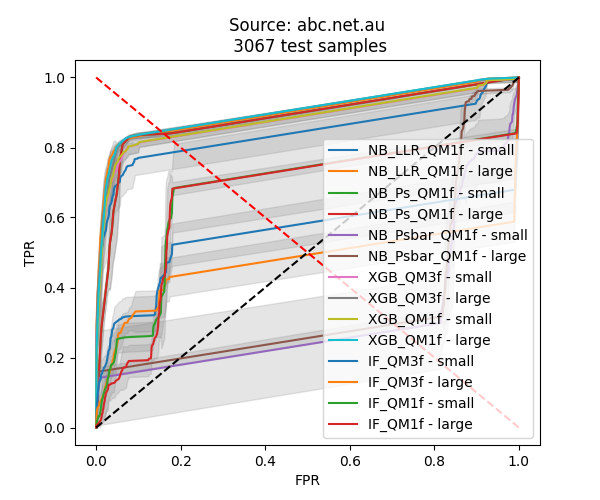

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
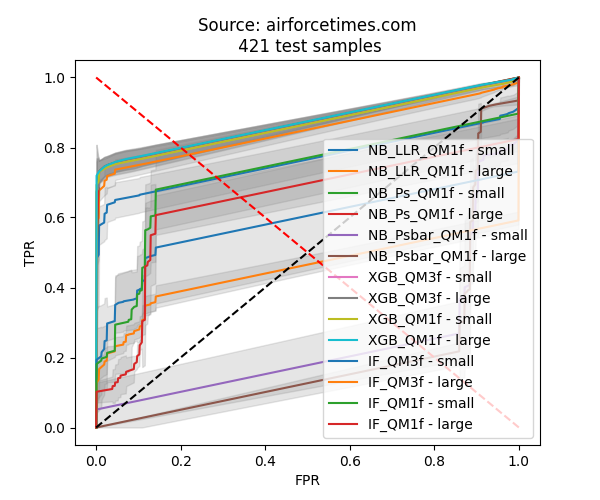

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
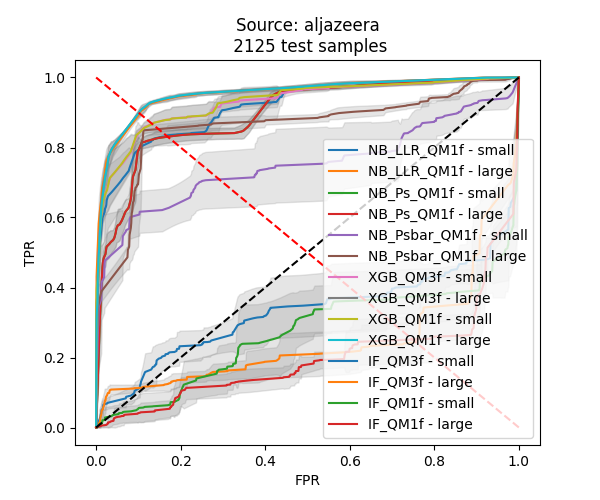

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
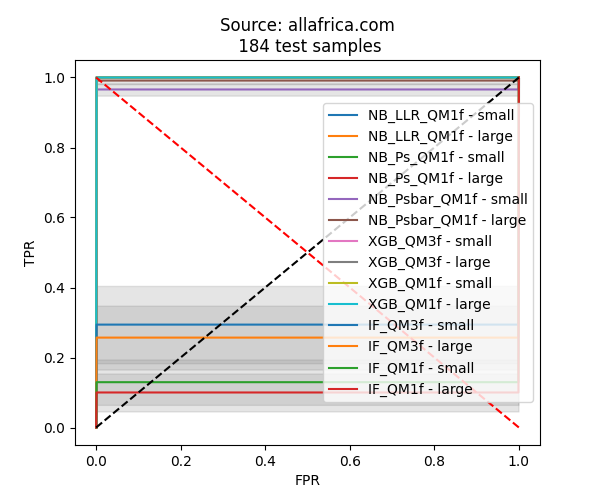

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
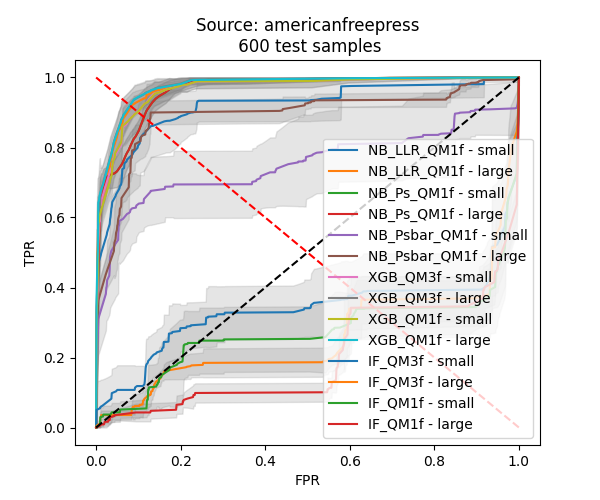

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
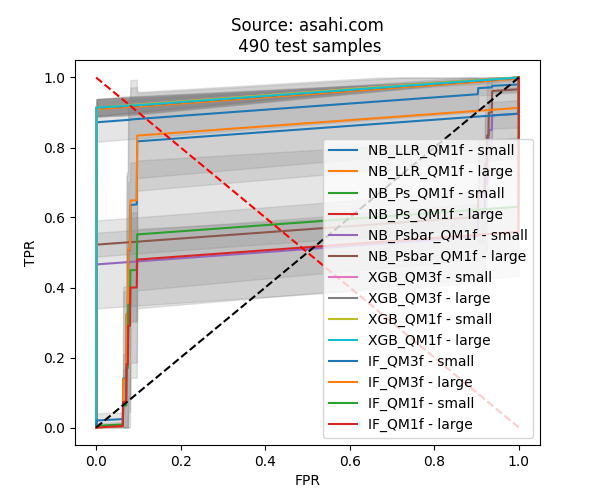

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
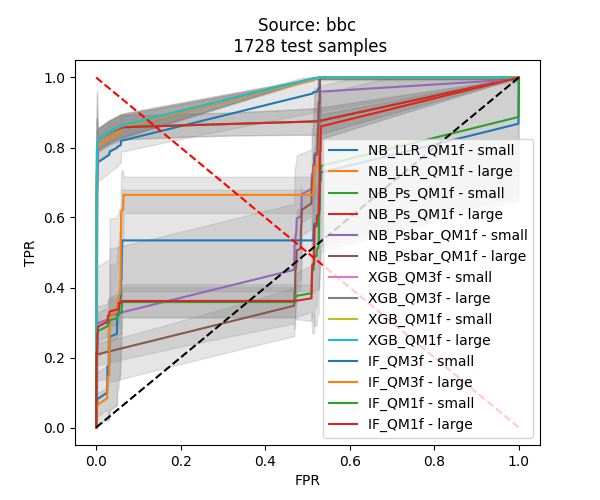

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
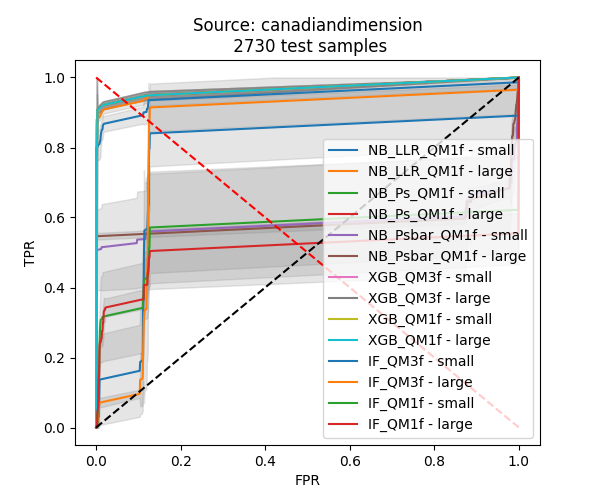

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
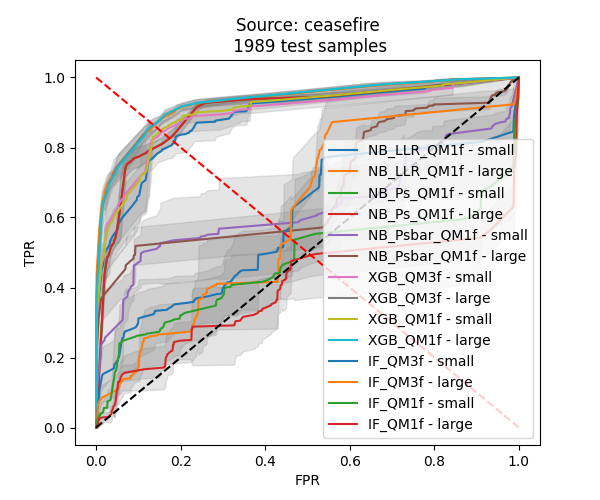

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
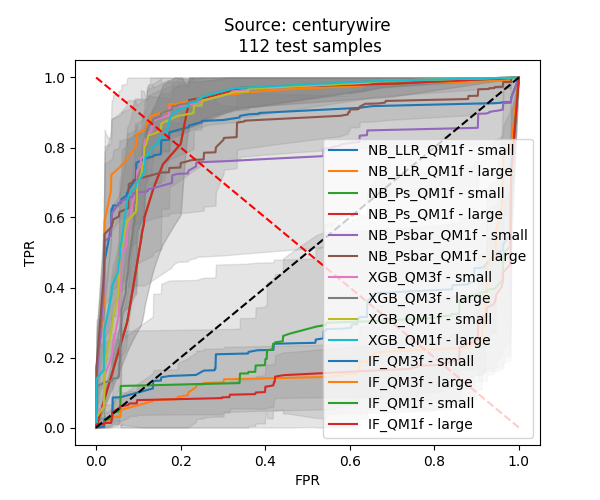

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
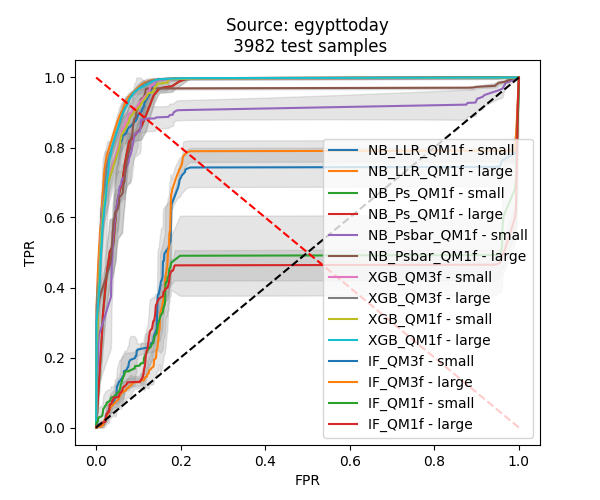

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
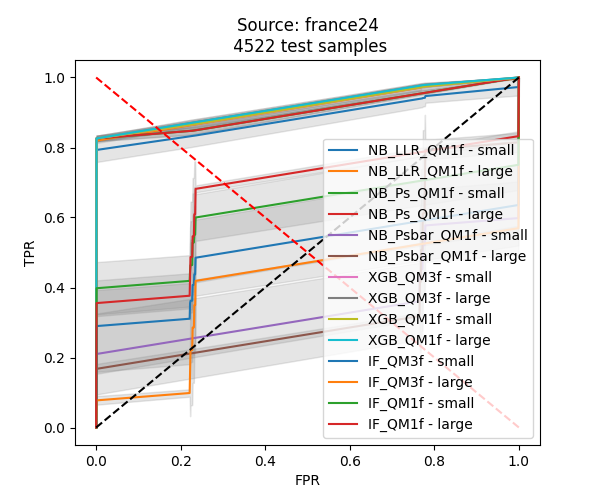

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
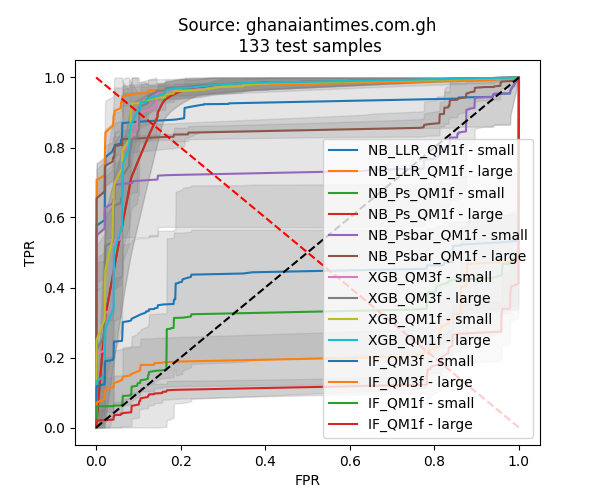

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
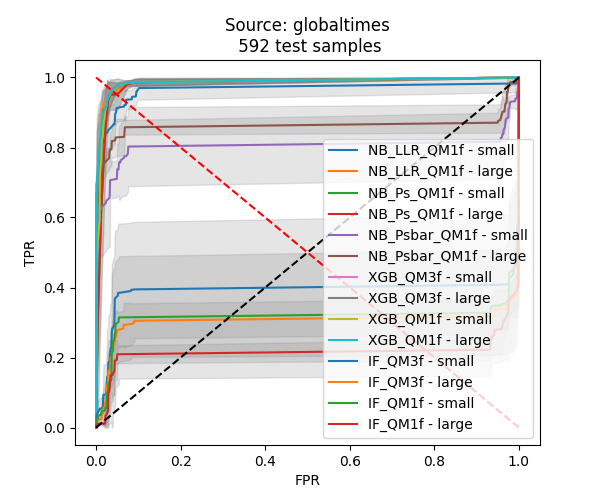

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
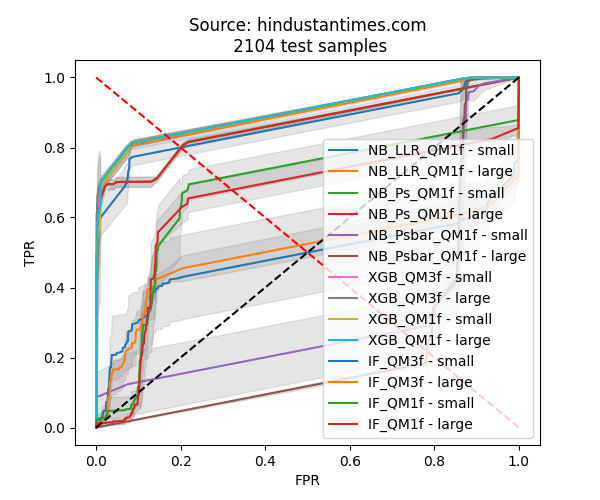

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
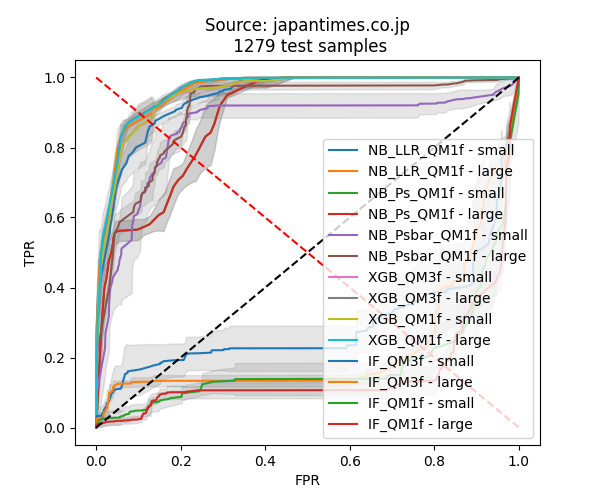

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
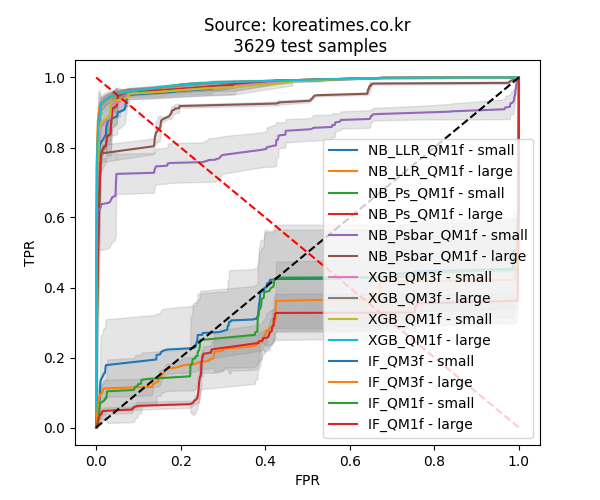

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
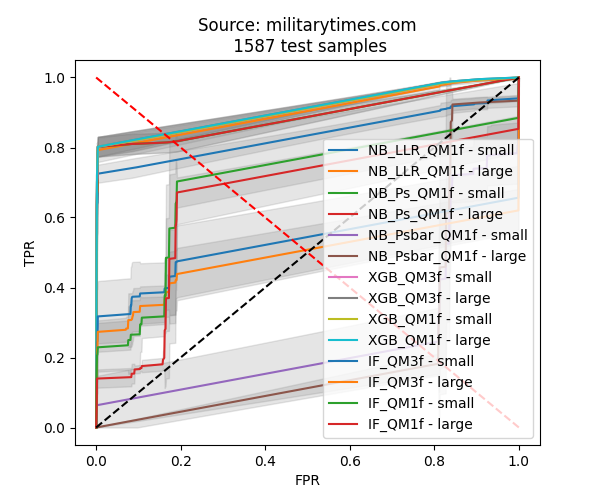

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
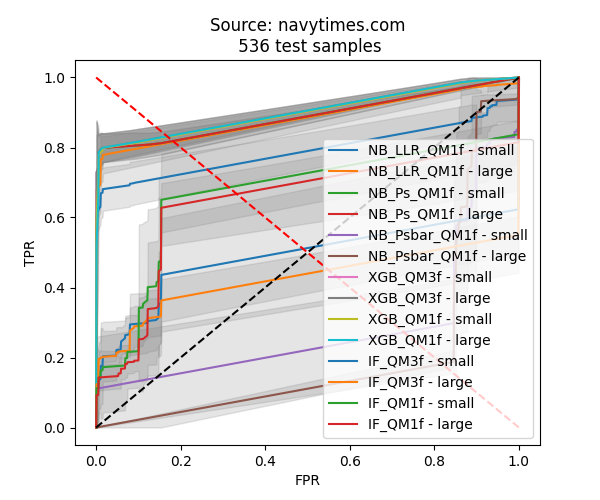

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
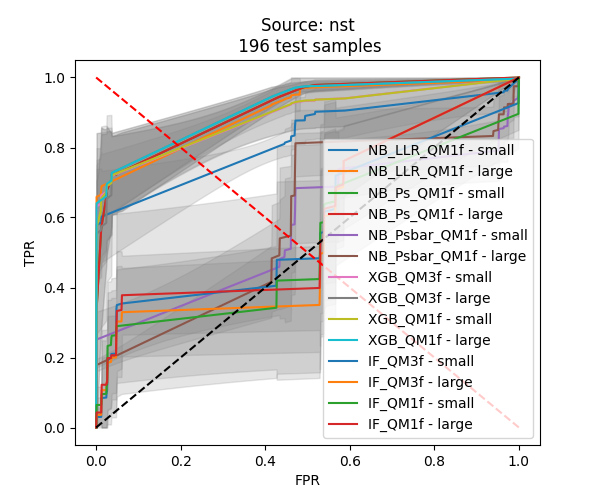

/tmp/ipykernel_917/1414464275.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
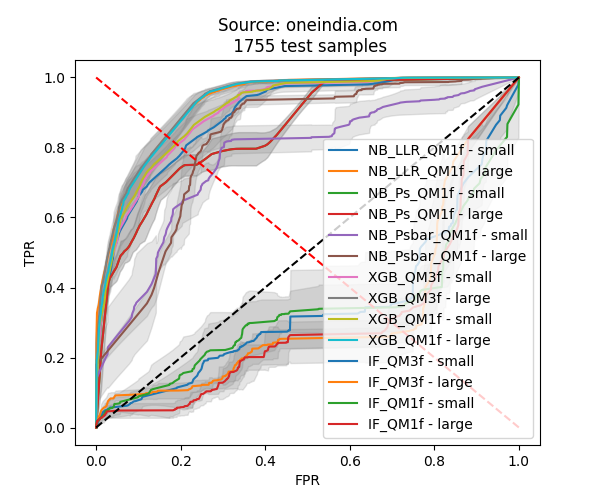

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
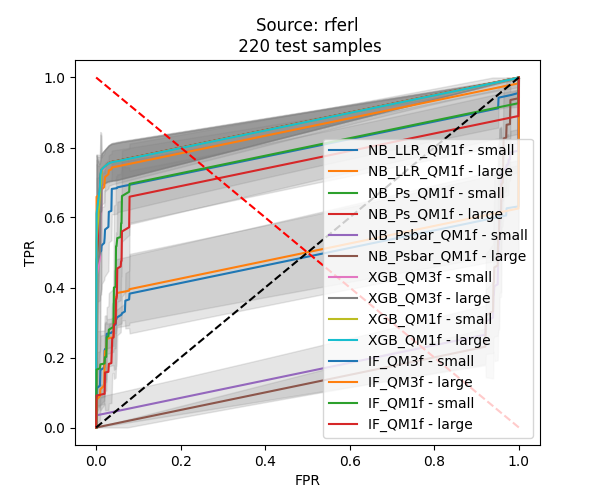

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
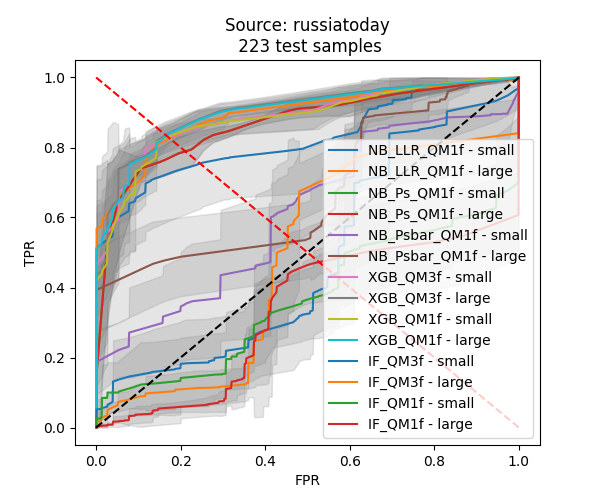

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
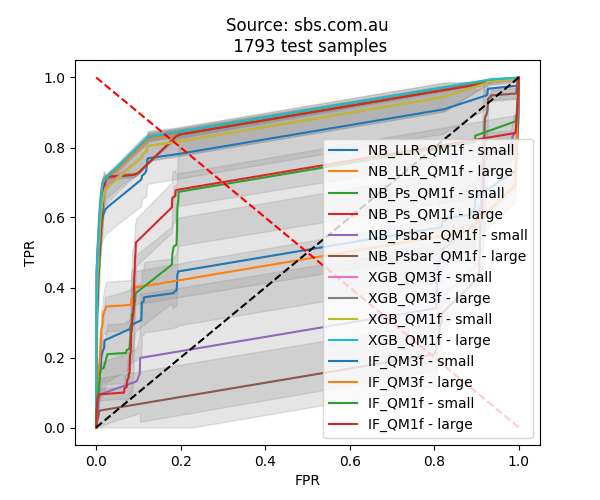

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
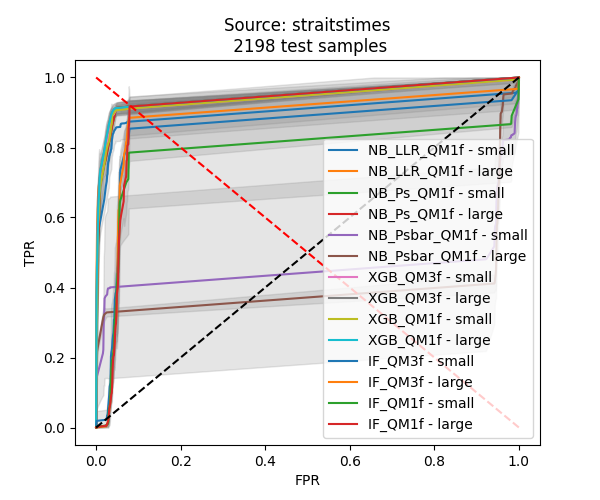

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
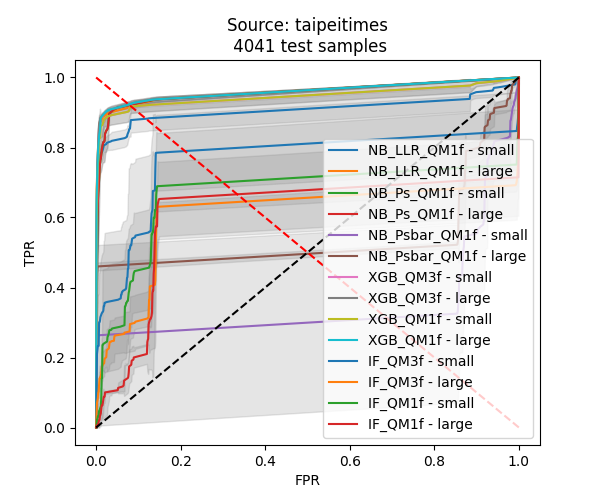

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
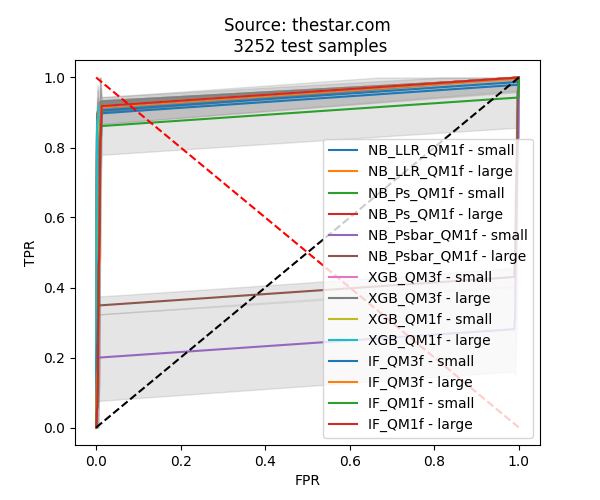

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
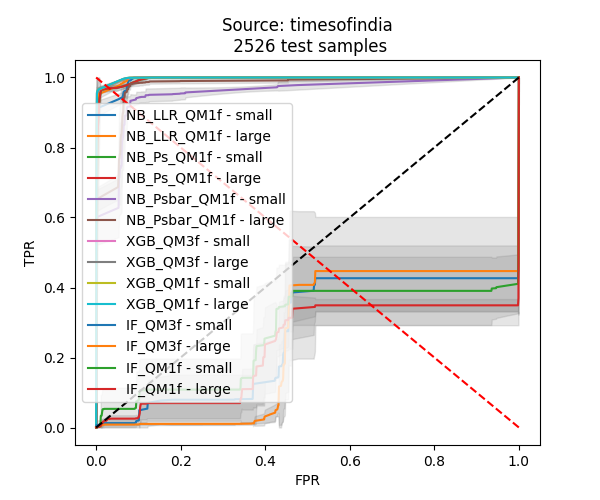

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
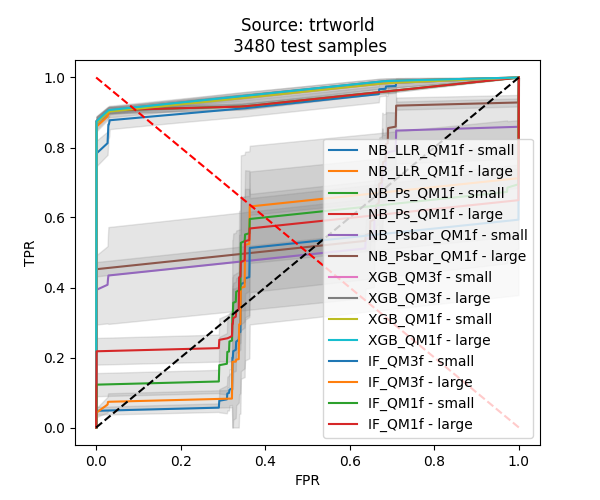

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
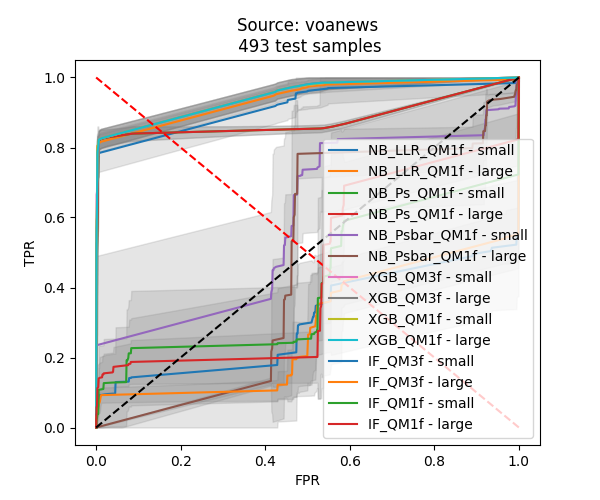

In [21]:
EERs_summary = {}
for model_name in model_names:
  EERs_summary[model_name] = {}
  for size_name in size_names:
    EERs_summary[model_name][size_name]={"EERs_over_trials":[], #each entry is array of 5 EERs from the 5 trials for a source
                                         "EERs_mean":[],        #each entry is mean over trials for a source source
                                         "EERs_std":[]          #each entry is std over trials for a source
                                        }

interp_fpr = np.linspace(0, 1, 1000)

for source in sources:
  plt.figure(figsize=(6,5))
  
  for model_name in model_names:
    for size_name in size_names:
      #Arrays, one entry per source. One array per model.
      EERs_over_trials = []
      EERs_mean = []  
      EERs_std = [] 
  
      interp_tprs_over_trials = []
    
      #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
      for trial in range(NUM_TRIALS):
        fpr = results[source][model_name][size_name][trial]['fpr']
        tpr = results[source][model_name][size_name][trial]['tpr']
        interp_tpr = np.interp(interp_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs_over_trials.append(interp_tpr)
      #------------
        EERs_over_trials.append(calculate_eer(interp_fpr, interp_tpr)) #get EER for this trial for this source
      
      EERs_summary[model_name][size_name]['EERs_over_trials'].append(EERs_over_trials)
      EERs_summary[model_name][size_name]['EERs_std'].append(np.std(EERs_over_trials))

      mean_tpr = np.mean(interp_tprs_over_trials, axis=0)
      mean_tpr[-1] = 1.0
  
      EERs_summary[model_name][size_name]['EERs_mean'].append(calculate_eer(interp_fpr, mean_tpr))
  
      std_tpr = np.std(interp_tprs_over_trials, axis=0)
      tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
      tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
      
      plt.plot(interp_fpr, mean_tpr,  linestyle="-", label="{} - {}".format(model_name, size_name))
      plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

      auc_mean = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_{}_{}'.format(model_name, size_name)])
      auc_std = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_{}_{}'.format(model_name, size_name)])
      tpr_at_fpr_mean = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_{}_{}'.format(model_name, size_name)])

      numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size_mean'])

      #-----------------------------------------------
  
  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="--")
  plt.title('Source: {}\n {} test samples'.format(
    source, numsamples))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend()
  #plt.tight_layout() 
  plt.show()
  #plt.savefig(os.path.join(RESULTS_FOLDER, "roc_{}.pdf".format(source)), bbox_inches='tight')
  
for model_name in model_names:
  for size_name in size_names:
    df_summary['EER_mean_{}_{}'.format(model_name, size_name)] = EERs_summary[model_name][size_name]['EERs_mean']
    df_summary['EER_std_{}_{}'.format(model_name, size_name)] = EERs_summary[model_name][size_name]['EERs_std']


In [22]:
# df_summary['AUC_formatted_small'] = uncertainty_format_arrays(df_summary['AUC_mean_qm_small'], df_summary['AUC_std_qm_small'])
# df_summary['AUC_formatted_big'] = uncertainty_format_arrays(df_summary['AUC_mean_qm_big'], df_summary['AUC_std_qm_big'])

In [22]:
df_summary.head()

source  test_size_mean  AUC_mean_NB_LLR_QM1f_small  AUC_mean_NB_LLR_QM1f_large  AUC_mean_NB_Ps_QM1f_small  AUC_mean_NB_Ps_QM1f_large  AUC_mean_NB_Psbar_QM1f_small  AUC_mean_NB_Psbar_QM1f_large  AUC_mean_XGB_QM3f_small  AUC_mean_XGB_QM3f_large  AUC_mean_XGB_QM1f_small  AUC_mean_XGB_QM1f_large  AUC_mean_IF_QM3f_small  AUC_mean_IF_QM3f_large  AUC_mean_IF_QM1f_small  AUC_mean_IF_QM1f_large  AUC_std_NB_LLR_QM1f_small  AUC_std_NB_LLR_QM1f_large  AUC_std_NB_Ps_QM1f_small  \
0         abc.net.au            3067                    0.841106                    0.901894                   0.882450                   0.882450                      0.313132                      0.350860                 0.881758                 0.902890                 0.882143                 0.903526                0.501249                0.459555                0.673279                0.663968                   0.043428                   0.003945                  0.003740   
1  airforcetimes.com             421                    0.764029                    0.849489                   0.872017                   0.872017                      0.235015                      0.203577                 0.867009                 0.872168                 0.866428                 0.874445                0.552533                0.450400                0.725118                0.645333                   0.045442                   0.017594                  0.015669   
2          aljazeera            2125                    0.914889                    0.955259                   0.895822                   0.895822                      0.751215                      0.861011                 0.927384                 0.954645                 0.930435                 0.954614                0.305987                0.243767                0.271107                0.198766                   0.015704                   0.002883                  0.007053   
3      allafrica.com             184                    1.000000                    1.000000                   1.000000                   1.000000                      0.965814                      0.991222                 1.000000                 1.000000                 1.000000                 1.000000                0.256033                0.288106                0.129466                0.100060                   0.000000                   0.000000                  0.000000   
4  americanfreepress             600                    0.917989                    0.972294                   0.962944                   0.962944                      0.753838                      0.893417                 0.966153                 0.975106                 0.966217                 0.975538                0.315679                0.246650                0.271078                0.203920                   0.041610                   0.006384                  0.007727   

   AUC_std_NB_Ps_QM1f_large  AUC_std_NB_Psbar_QM1f_small  AUC_std_NB_Psbar_QM1f_large  AUC_std_XGB_QM3f_small  AUC_std_XGB_QM3f_large  AUC_std_XGB_QM1f_small  AUC_std_XGB_QM1f_large  AUC_std_IF_QM3f_small  AUC_std_IF_QM3f_large  AUC_std_IF_QM1f_small  AUC_std_IF_QM1f_large  tpr_at_fpr_mean_NB_LLR_QM1f_small  tpr_at_fpr_mean_NB_LLR_QM1f_large  tpr_at_fpr_mean_NB_Ps_QM1f_small  tpr_at_fpr_mean_NB_Ps_QM1f_large  tpr_at_fpr_mean_NB_Psbar_QM1f_small  tpr_at_fpr_mean_NB_Psbar_QM1f_large  \
0                  0.003740                     0.106330                     0.012777                0.012603                0.003094                0.011061                0.003445               0.078861               0.033273               0.103483               0.017310                           0.326927                           0.416243                          0.117145                          0.117145                             0.108455                             0.157957   
1                  0.015669                     0.073275                     0.013477                0.017446          

In [23]:
print(len(df_train_small['source'].unique()))

df_train_small['source'].unique()

15


array(['allafrica.com', 'americanfreepress', 'canadiandimension',
       'centurywire', 'globaltimes', 'hindustantimes.com',
       'koreatimes.co.kr', 'militarytimes.com', 'navytimes.com', 'nst',
       'rferl', 'russiatoday', 'timesofindia', 'trtworld', 'voanews'],
      dtype=object)

In [23]:
print(len(df_train_big['source'].unique()))

df_train_big['source'].unique()

30


array(['abc.net.au', 'airforcetimes.com', 'aljazeera', 'allafrica.com',
       'americanfreepress', 'asahi.com', 'bbc', 'canadiandimension',
       'ceasefire', 'centurywire', 'egypttoday', 'france24',
       'ghanaiantimes.com.gh', 'globaltimes', 'hindustantimes.com',
       'japantimes.co.jp', 'koreatimes.co.kr', 'militarytimes.com',
       'navytimes.com', 'nst', 'oneindia.com', 'rferl', 'russiatoday',
       'sbs.com.au', 'straitstimes', 'taipeitimes', 'thestar.com',
       'timesofindia', 'trtworld', 'voanews'], dtype=object)

In [24]:
# df_latex = df_summary[['source', 'test_size', 'AUC_formatted_big', 'AUC_formatted_small', 'tpr_at_fpr_mean_qm_big', 'tpr_at_fpr_mean_qm_small', 'EER_mean_qm_big','EER_mean_qm_small']]
# df_latex.columns=['source', 'test size', 'AUC (full)', 'AUC (half)', 'tpr@fpr (full)', 'tpr@fpr (half)', 'EER (full)','EER (half)']
# df_latex

In [25]:
# # 3 sig figs use '%.3g'; 3 digits use '%.3f'
# latex_table = df_latex.to_latex(index=False, float_format='%.3g')
# with open(os.path.join(RESULTS_FOLDER,"table1.tex"),"w") as file1:
#   file1.write(latex_table)

### Make separate plots for each model

Warning: this sometimes crashes the Jupyter notebook, from too many plots. So be careful running this. One option is to run it, and as soon as the files save, clear the cell's output.

In [ ]:
for source in sources: 
  for model_name in model_names:
    plt.figure(figsize=(6,5))
    for size_name in size_names:
      interp_tprs_over_trials = []
    
      #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
      for trial in range(NUM_TRIALS):
        fpr = results[source][model_name][size_name][trial]['fpr']
        tpr = results[source][model_name][size_name][trial]['tpr']
        interp_tpr = np.interp(interp_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs_over_trials.append(interp_tpr)
      #------------

      mean_tpr = np.mean(interp_tprs_over_trials, axis=0)
      mean_tpr[-1] = 1.0
  
      std_tpr = np.std(interp_tprs_over_trials, axis=0)
      tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
      tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
      
      plt.plot(interp_fpr, mean_tpr,  linestyle="-", label="{} - {}".format(model_name, size_name))
      plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
  
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="--")
    plt.title('Source: {}\n {} test samples'.format(
      source, numsamples))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    #plt.tight_layout() 
    #plt.show()
    plt.savefig(os.path.join(RESULTS_FOLDER, "roc_{}_{}.pdf".format(source, model_name)), bbox_inches='tight')

  

In [22]:
df_metricplot =  df_summary.sort_values(by='AUC_mean_XGB_QM3f_large', ascending=False).reset_index(drop=True)
sources_metricplot = list(df_metricplot['source'])

colors = ["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:blue", 
          "tab:brown", "tab:pink", "tab:grey", "tab:olive", "tab:cyan" ]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
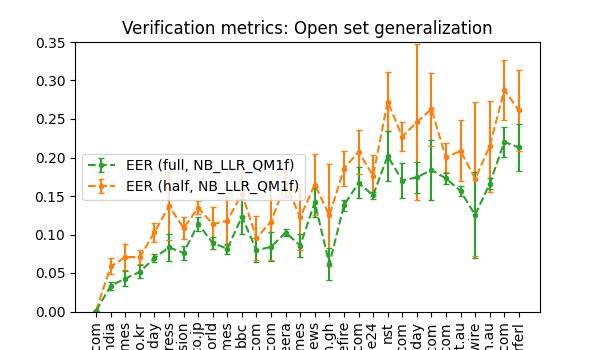

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
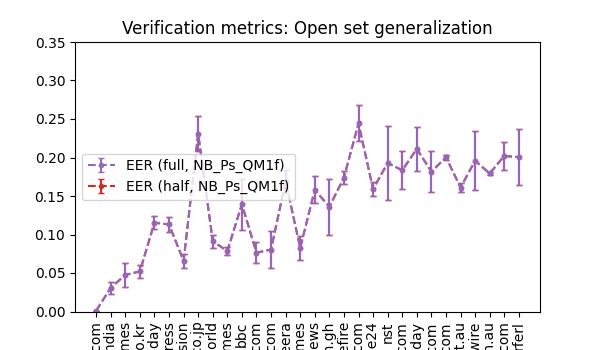

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
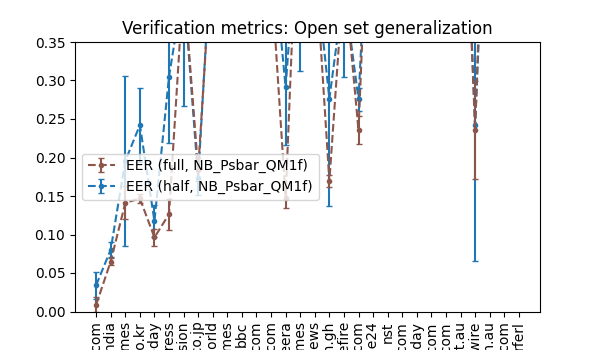

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
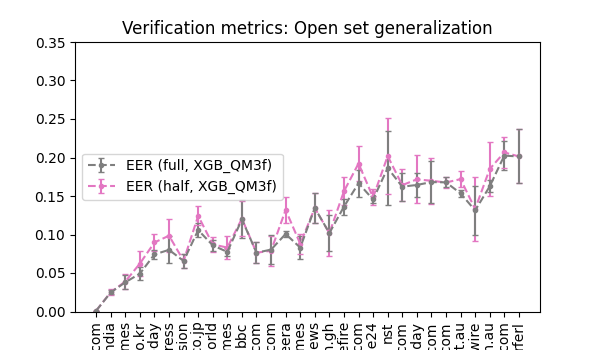

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
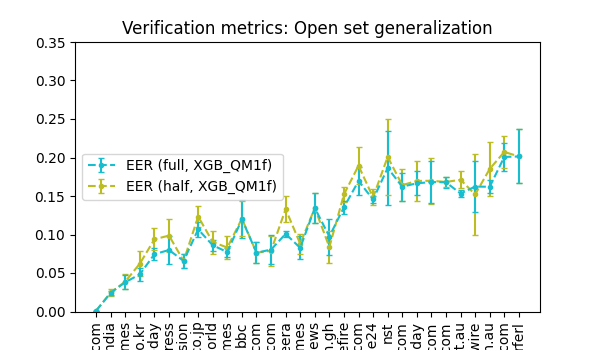

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
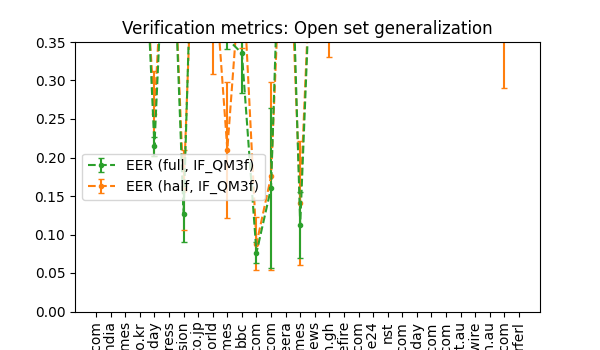

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
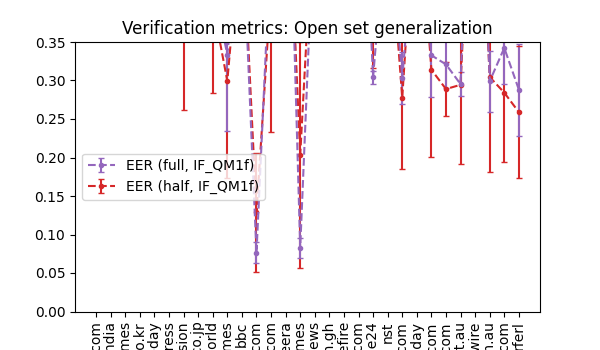

In [23]:

x_vals = [i for i,_ in enumerate(sources_metricplot)]
size_labels = ['half', 'full']

cindx = 0
for model_name in model_names:
  plt.figure(figsize=(6,3.5))
  for sindx, size_name in enumerate(size_names):
    cindx = cindx % len(colors)
    cindx += 1
    color = colors[cindx-1]
    slabel = size_labels[sindx]

    plt.errorbar(x_vals, df_metricplot['EER_mean_{}_{}'.format(model_name,size_name)], 
                 yerr=df_metricplot['EER_std_{}_{}'.format(model_name,size_name)],
                 fmt=".", linestyle="--", 
                 label="EER ({}, {})".format(slabel, model_name), color=color,
                 mfc=color, mec=color, ecolor=color, capsize=2)

  plt.xticks(x_vals, sources_metricplot, rotation=90)

  # handles, labels = plt.gca().get_legend_handles_labels()
  # handles = [handles[3], handles[2], handles[1], handles[0]]
  # labels = [labels[3], labels[2], labels[1], labels[0]]
  # plt.legend(handles, labels, loc="center left")
  handles, labels = plt.gca().get_legend_handles_labels()
  handles.reverse()
  labels.reverse()
  plt.legend(handles, labels, loc="center left")

  plt.ylim(0,0.35)
  plt.title("Verification metrics: Open set generalization")

  # plt.tight_layout()
  plt.show()
  # #uncomment to save:
  # plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
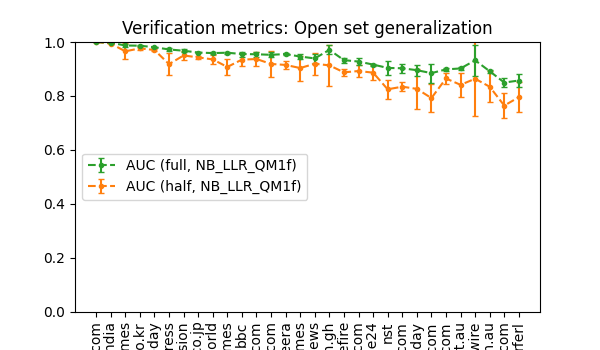

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
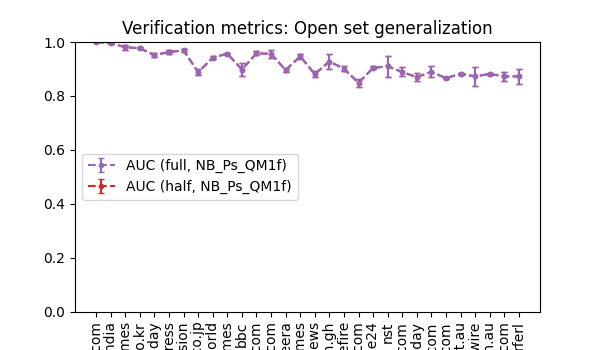

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
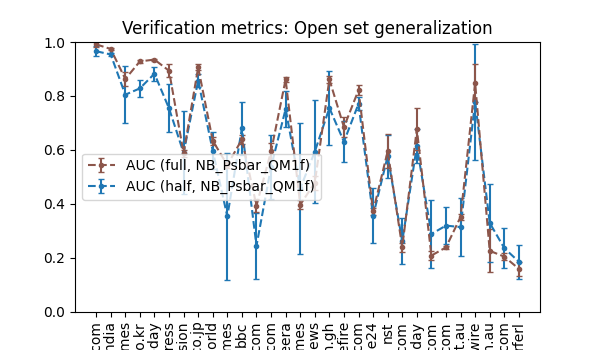

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
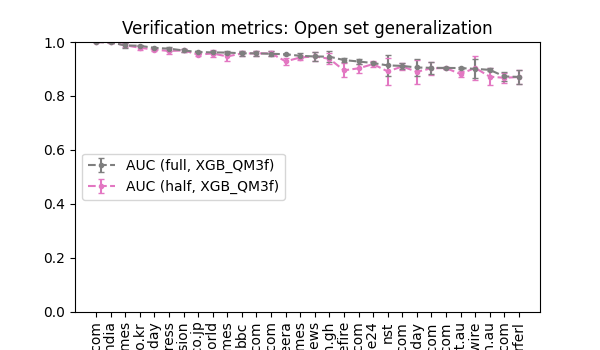

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
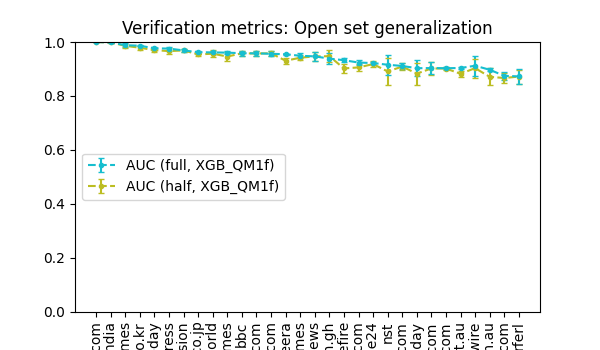

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
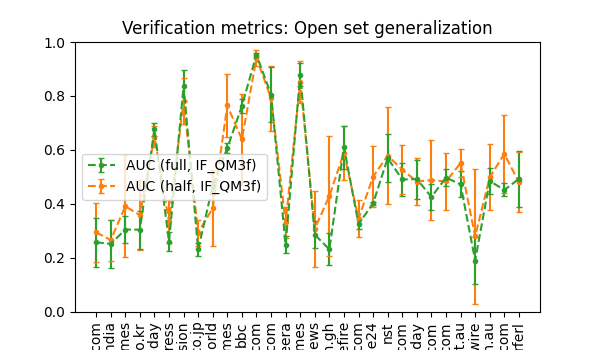

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
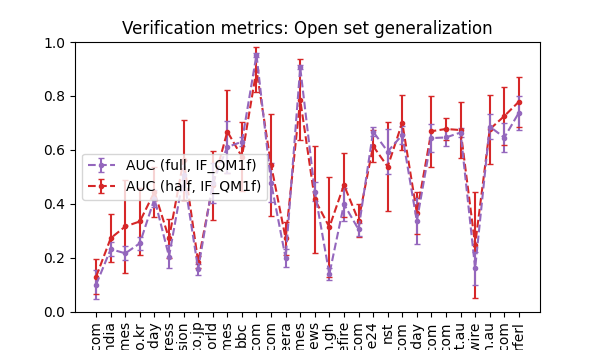

In [24]:
cindx = 0
for model_name in model_names:
  plt.figure(figsize=(6,3.5))
  for sindx, size_name in enumerate(size_names):
    cindx = cindx % len(colors)
    cindx += 1
    color = colors[cindx-1]
    slabel = size_labels[sindx]

    plt.errorbar(x_vals, df_metricplot['AUC_mean_{}_{}'.format(model_name,size_name)], 
                 yerr=df_metricplot['AUC_std_{}_{}'.format(model_name,size_name)],
                 fmt=".", linestyle="--", 
                 label="AUC ({}, {})".format(slabel, model_name), color=color,
                 mfc=color, mec=color, ecolor=color, capsize=2)

  plt.xticks(x_vals, sources_metricplot, rotation=90)

  # handles, labels = plt.gca().get_legend_handles_labels()
  # handles = [handles[3], handles[2], handles[1], handles[0]]
  # labels = [labels[3], labels[2], labels[1], labels[0]]
  # plt.legend(handles, labels, loc="center left")
  handles, labels = plt.gca().get_legend_handles_labels()
  handles.reverse()
  labels.reverse()
  plt.legend(handles, labels, loc="center left")

  plt.ylim(0,1.0)
  plt.title("Verification metrics: Open set generalization")

  # plt.tight_layout()
  plt.show()
  # #uncomment to save:
  # plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

In [25]:
print("printing mean AUCs -- averaged across all sources -- for each model\n")
df_summary.loc[:,df_summary.columns.str.startswith("AUC_mean")].mean().sort_values(ascending=False)

model_names_to_print = ['XGB_QM3f', 'XGB_QM1f', 'NB_LLR_QM1f','NB_Ps_QM1f','NB_Psbar_QM1f', 'IF_QM3f', 'IF_QM1f']

print("        model     full   half    diff")
for model_name in model_names_to_print:
  mean_small = df_summary['AUC_mean_{}_small'.format(model_name)].mean()
  mean_large = df_summary['AUC_mean_{}_large'.format(model_name)].mean()
  print("{:>14}   {:.3f}   {:.3f}   {:.3f}".format(model_name, mean_large, mean_small, mean_large-mean_small))

printing mean AUCs -- averaged across all sources -- for each model

        model     full   half    diff
      XGB_QM3f   0.940   0.932   0.008
      XGB_QM1f   0.940   0.932   0.008
   NB_LLR_QM1f   0.938   0.897   0.041
    NB_Ps_QM1f   0.918   0.918   0.000
 NB_Psbar_QM1f   0.603   0.575   0.028
       IF_QM3f   0.475   0.506   -0.031
       IF_QM1f   0.469   0.497   -0.029


In [26]:
print("printing mean EERs -- averaged across all sources -- for each model\n")
df_summary.loc[:,df_summary.columns.str.startswith("AUC_mean")].mean().sort_values(ascending=False)

model_names_to_print = ['XGB_QM3f', 'XGB_QM1f', 'NB_LLR_QM1f','NB_Ps_QM1f','NB_Psbar_QM1f', 'IF_QM3f', 'IF_QM1f']

print("        model     full   half    diff")
for model_name in model_names_to_print:
  mean_small = df_summary['EER_mean_{}_small'.format(model_name)].mean()
  mean_large = df_summary['EER_mean_{}_large'.format(model_name)].mean()
  print("{:>14}   {:.3f}   {:.3f}   {:.3f}".format(model_name, mean_large, mean_small, mean_small-mean_large))

printing mean EERs -- averaged across all sources -- for each model

        model     full   half    diff
      XGB_QM3f   0.115   0.123   0.008
      XGB_QM1f   0.116   0.123   0.007
   NB_LLR_QM1f   0.119   0.159   0.041
    NB_Ps_QM1f   0.138   0.138   0.000
 NB_Psbar_QM1f   0.438   0.455   0.017
       IF_QM3f   0.498   0.469   -0.029
       IF_QM1f   0.503   0.475   -0.028


## Save summary stats to text files

In [27]:
for metric_name in ["AUC", "EER"]:
  for model_name in ["XGB_QM1f", "NB_LLR_QM1f", "NB_Ps_QM1f", "NB_Psbar_QM1f"]:
    for size_name in size_names:
      mean_val = df_summary['{}_mean_{}_{}'.format(metric_name, model_name, size_name)].mean()
      print("mean {} across all sources ({}-{}) was {:.2f}".format(metric_name, model_name, size_name, mean_val))
      with open(os.path.join(RESULTS_FOLDER,
        "{}_avg_across_sources_{}_{}.txt".format(metric_name, model_name, size_name)),"w") as file1:
          file1.write("{:.2f}".format(mean_val))
      
    diff_val = df_summary['{}_mean_{}_{}'.format(metric_name, model_name, 'small')].mean() - \
               df_summary['{}_mean_{}_{}'.format(metric_name, model_name, 'large')].mean()
    if metric_name == "AUC":
      diff_val = - diff_val
    if diff_val == -0.0: #fix bad formattting
      diff_val = 0.0
    print("diff in mean {} across all sources ({}) was {:.3f}\n".format(metric_name, model_name, diff_val))
    with open(os.path.join(RESULTS_FOLDER,
        "{}_avg_diff_across_sources_{}.txt".format(metric_name, model_name, size_name)),"w") as file1:
          file1.write("{:.2f}".format(diff_val))

mean AUC across all sources (XGB_QM1f-small) was 0.93
mean AUC across all sources (XGB_QM1f-large) was 0.94
diff in mean AUC across all sources (XGB_QM1f) was 0.008

mean AUC across all sources (NB_LLR_QM1f-small) was 0.90
mean AUC across all sources (NB_LLR_QM1f-large) was 0.94
diff in mean AUC across all sources (NB_LLR_QM1f) was 0.041

mean AUC across all sources (NB_Ps_QM1f-small) was 0.92
mean AUC across all sources (NB_Ps_QM1f-large) was 0.92
diff in mean AUC across all sources (NB_Ps_QM1f) was 0.000

mean AUC across all sources (NB_Psbar_QM1f-small) was 0.58
mean AUC across all sources (NB_Psbar_QM1f-large) was 0.60
diff in mean AUC across all sources (NB_Psbar_QM1f) was 0.028

mean EER across all sources (XGB_QM1f-small) was 0.12
mean EER across all sources (XGB_QM1f-large) was 0.12
diff in mean EER across all sources (XGB_QM1f) was 0.007

mean EER across all sources (NB_LLR_QM1f-small) was 0.16
mean EER across all sources (NB_LLR_QM1f-large) was 0.12
diff in mean EER across al

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
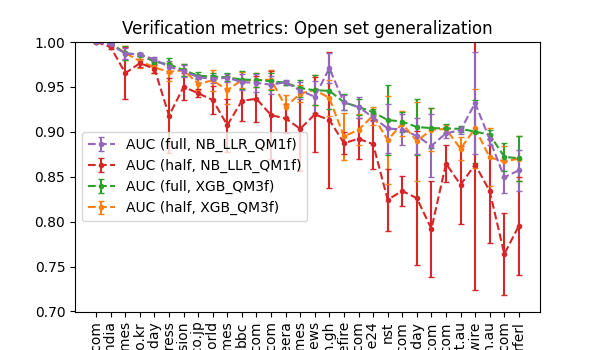

In [28]:
model_names_to_graph = ['XGB_QM3f', 'NB_LLR_QM1f']

cindx = 0
plt.figure(figsize=(6,3.5))
for model_name in model_names_to_graph:
  for sindx, size_name in enumerate(size_names):
    cindx += 1
    color = colors[cindx-1]
    slabel = size_labels[sindx]

    plt.errorbar(x_vals, df_metricplot['AUC_mean_{}_{}'.format(model_name,size_name)], 
                 yerr=df_metricplot['AUC_std_{}_{}'.format(model_name,size_name)],
                 fmt=".", linestyle="--", 
                 label="AUC ({}, {})".format(slabel, model_name), color=color,
                 mfc=color, mec=color, ecolor=color, capsize=2)

plt.xticks(x_vals, sources_metricplot, rotation=90)

# handles, labels = plt.gca().get_legend_handles_labels()
# handles = [handles[3], handles[2], handles[1], handles[0]]
# labels = [labels[3], labels[2], labels[1], labels[0]]
# plt.legend(handles, labels, loc="center left")
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles, labels, loc="center left")

plt.ylim(0,1.0)
plt.title("Verification metrics: Open set generalization")

plt.ylim(.7,1.0)

# plt.tight_layout()
plt.show()
# #uncomment to save:
# plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')



## Try different graph variants for paper

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
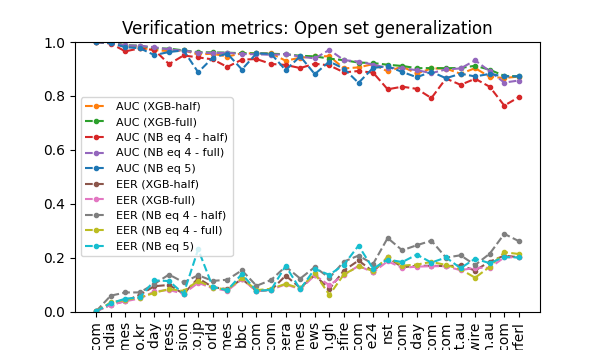

In [29]:
model_names_to_graph = ['XGB_QM1f', 'NB_LLR_QM1f', "NB_Ps_QM1f"]

fig_labels = {"XGB_QM1f":   {"small":"XGB-half",
                             "large":"XGB-full"},
              "NB_LLR_QM1f":{"small":"NB eq 4 - half",
                             "large":"NB eq 4 - full"},
              "NB_Ps_QM1f":"NB eq 5"
              } 


cindx = 0
plt.figure(figsize=(6,3.5))
for metric_name in ["AUC", "EER"]:              
  for model_name in model_names_to_graph:
    if model_name == "NB_Ps_QM1f":
      cindx += 1
      color = colors[cindx-1]
      #for NB_Ps_QM1f, 'small' and 'large' are identical since classifier only trained on samples from source s.
      plt.plot(x_vals, df_metricplot['{}_mean_{}_{}'.format(metric_name,model_name,"small")], 
                   linestyle="--", marker='.',
                   label="{} ({})".format(metric_name, fig_labels[model_name]), color=color)
    else:
      for sindx, size_name in enumerate(size_names):
        cindx += 1
        color = colors[cindx-1]
        slabel = size_labels[sindx]

        plt.plot(x_vals, df_metricplot['{}_mean_{}_{}'.format(metric_name,model_name,size_name)], 
                     linestyle="--", marker='.',
                     label="{} ({})".format(metric_name, fig_labels[model_name][size_name]), color=color)

plt.xticks(x_vals, sources_metricplot, rotation=90)

handles, labels = plt.gca().get_legend_handles_labels()
# handles.reverse()
# labels.reverse()
plt.legend(handles, labels, loc="center left", prop={'size': 8})

plt.ylim(0,1.0)
plt.title("Verification metrics: Open set generalization")

# plt.ylim(.7,1.0)

# plt.tight_layout()
plt.show()
#uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

